## 1. 사진 준비하기
스티커를 세밀하고 자연스럽게 적용하기 위해서 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요합니다. 이 위치들을 찾아내는 기술을 랜드마크 landmark 또는 조정 alignment 이라고 합니다. 조금 더 큰 범위로는 keypoint detection 이라고 부르고 있습니다. 대부분의 face landmark 데이터셋은 눈, 코, 입과 턱을 포함하고 있습니다. 얼굴의 랜드마크를 찾아냈다면 머리의 위치를 예상하는 것은 쉽습니다. 눈과 코의 위치로부터 위로 떨어져 있는 정도를 데이터로부터 유추할 수 있을 겁니다.

1. 얼굴이 포함된 사진 준비

2. 얼굴이 포함된 사진을 준비하고
사진으로부터 얼굴 영역 face landmark 를 찾아냅니다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야합니다.)

3. 찾아진 영역으로 부터 머리에 왕관 스티커를 붙여넣겠습니다.

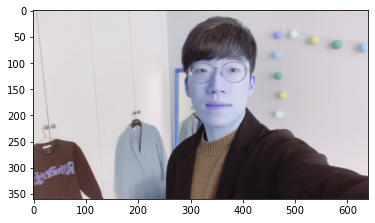

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
my_image_path = os.getenv('HOME')+'/workplace/aiffel/Exploration/10.camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

#### opencv
- 예외적으로 BGR (파랑, 녹색, 빨강) 사용하기 때문에 원본 RGB 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력
- 다른 이미지 라이브러리 활용하여 색깔 보정처리 필요

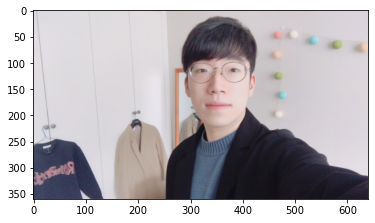

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html

#### cv2.imread('img.png', 0) 에서 0 은 무슨 의미일까요?
이미지 읽기의 flag는 다음 3가지가 있습니다.   순서대로 1, 0, -1의 값을 갖습니다. 

cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.
cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.

cv2.imread('img.png', 0)이라고 호출했다면 이미지를 Grayscale로 읽어 들이겠다는 뜻입니다. 실제로 이미지 읽기 flag를 바꿔가면서 이미지가 어떻게 출력되는지 확인해 보세요.

## 2. 얼굴 검출 face detection
dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다. 

https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c

#### 이미지에서 그래디언트gradient를 특징feature으로 사용하는 이유는 무엇인가요?
픽셀을 직접 분석하면, 동일한 사람의 정말 어두운 이미지와 정말 밝은 이미지는 전혀 다른 픽셀값을 갖게 될 것입니다. 그러나 밝기가 변하는 방향 만 고려하면 정말 어두운 이미지와 정말 밝은 이미지에 대한 완전히 동일한 표현(representation)을 얻게 됩니다. 이렇게 하면 문제를 훨씬 더 쉽게 해결할 수 있습니다!

픽셀의 RGB값 자체보다는 인접한 픽셀들 사이의 색상 변화율 자체에 오브젝트의 특징이 더욱 정확히 반영될 때가 많기 때문이다. 예를 들어, 동일한 오브젝트라도 밝을 때와 어두울 때의 픽셀값의 분포는 완전히 다르지만, 밝기가 변하는 방향(그래디언트)만 고려하면 주변 상황과 무관하게 동일한 표현(representation)을 얻을 수 있다.

#### 단일 픽셀의 그래디언트를 사용하지 않고 16x16 의 정사각형을 이용하는 무엇일까요?
모든 단일 픽셀에 대해 그래디언트를 저장하면 너무 자세합니다. 이렇게 되면 결국 우리는 나무를 보고 숲을 보지 못하게 됩니다. 이미지의 기본 패턴을 알 수 있도록, 높은 수준에서 밝음/어둠의 기본 흐름만을 보는 것이 더 좋습니다.

이미지를 각각 16x16 픽셀의 작은 정사각형들으로 분해합니다. 각 정사각형에서, 우리는 얼마나 많은 그래디언트가 주요 방향(윗쪽, 우상쪽, 오른쪽, 등)을 얼마나 가리키고 있는지 세어 볼 것입니다 . 그런 다음 이 사각형을 가장 강한 화살표 방향으로 바꿀 것입니다.

In [4]:
# hog detector를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [5]:
# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # bgr -> rgb
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


#### Image Pyramids
동일 이미지의 서로 다른 사이즈의 set을 Image Pyramids라고 합니다(가장 아래에 가장 큰 해상도를 놓고 점점 줄여가면서 쌓아가는 형태).
- Gaussian Pyramids
- Laplacian Pyramids

rectangles[[(270, 64) (425, 219)]]


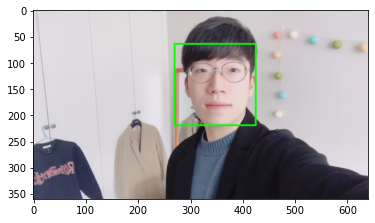

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 얼굴 랜드마크 face landmark
- 이목구비 위치 추론: face landmark localization 기술
-  face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용

#### Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

### Dlib landmark localization

In [7]:
import os
model_path = os.getenv('HOME')+'/workplace/aiffel/Exploration/10.camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [8]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) 
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


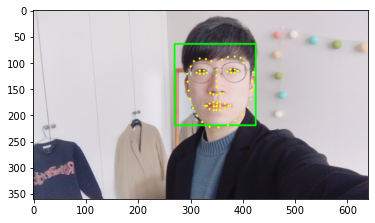

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용하기

1. 스티커 위치

$\begin{aligned} x &= x_{nose} \\ y &= y_{nose}-\frac{width}{2} \end{aligned}$

2. 스티커 크기

$width=height=width_{bbox}$

In [10]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(350, 146)
(x,y) : (350,68)
(w,h) : (156,156)


In [11]:
# 스티커 읽어서 적용
import os
sticker_path = os.getenv('HOME')+'/workplace/aiffel/Exploration/10.camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


In [18]:
# x,y 좌표 조정
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (194,-88)


In [19]:
# 원본 이미지 범위 벗어난 스티커 부분 제거
# -y 크기만큼 스티터 crop
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(0, 156, 3)


In [20]:
# top 의 y 좌표는 원본 이미지 경계 값으로 수정
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (194,0)


In [21]:
# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다. 예제에서는 (566,0) 부터 (566+268, 0+157) 범위의 이미지를 의미

스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용

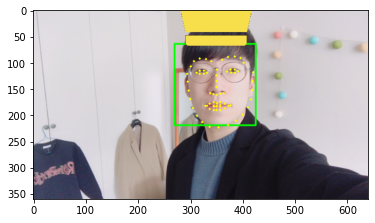

In [22]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

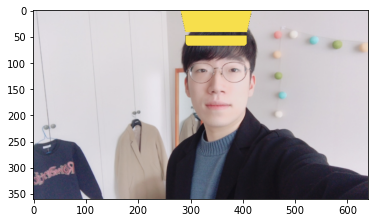

In [23]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()